In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from nrclex import NRCLex
import torch
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, pipeline
from sklearn.model_selection import train_test_split
from torch.optim import AdamW

2023-09-08 11:51:34.084992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df=pd.read_csv("df1.csv")
del df["Unnamed: 0"]
del df['Unnamed: 12']
del df["Unnamed: 13"]
del df['Unnamed: 14']

In [3]:
#preprocessing
mapping={
    'private':0,
    'privae':0,
    'media':1,
    'bot':2,
    'anger':0,
    'disgust':1,
    'fear':2,
    'joy':3,
    'neutral':4,
    'sadness':5,
    'surprise':6
}
df['account type']= df['account type'].replace(mapping)
df['emotions']= df['emotions'].replace(mapping)
df['account type']=df['account type'].astype(int, errors='ignore')
df['emotions']=pd.to_numeric(df['emotions'], errors='coerce', downcast='integer')
df.rename(columns={'annotation1': 'Annotation', 'tweet':'Tweet','likes':'Likes','comments':'Comments','retweet':'Retweet','account type':'Account Type','following':'Following','followers':"Followers",'emotions':'Emotions'}, inplace=True)
df['Annotation']=df['Annotation'].replace(1,0)
df['Annotation']=df['Annotation'].replace(-1,1)

In [4]:
df

,Annotation,Tweet,Likes,Comments,Retweet,Account Type,Following,Followers,Sentiment,Emotions,emotions_string
0,0,People urgently need reliable and accurate inf...,1756,135,650,0.0,1873,1959628,7.40,3.0,"reliability, determined,"
1,0,"If any of y’all think coronavirus is “gone,” o...",7,0,3,0.0,148,65,2.40,1.0,"anger, disgust, hostile"
2,0,Facebook will start steering users who interac...,0,0,1,0.0,3101,9323,5.40,4.0,"neutral, information"
3,0,I sure hope this survey was anonymous. 4 perce...,0,0,0,0.0,666,930,3.60,1.0,"disgust, disbelief"
4,1,Q'd Drop Doctor speaks about hydroxychloroquin...,1,0,0,0.0,756,1339,4.80,4.0,neutral
...,...,...,...,...,...,...,...,...,...,...,...
595,1,Do a search for Dr Richard Bartlett on Youtube...,0,0,0,0.0,471,430,7.00,3.0,"hope, disgust"
596,1,A friend sent us this interview with an ER Doc...,0,0,0,1.0,1723,310,4.25,3.0,"sad, hope"
597,0,"No, 5G radiation doesn't cause or spread the #...",48,4,24,0.0,5982,88405,7.00,2.0,"stern, annoyance, joy"
598,0,"You took it for ""malaria prevention."" Which i...",3,0,1,0.0,379,466,3.25,0.0,"anger, irritated, fear, interested, paranoid"


In [5]:
dfconsp=df[df['Annotation']==1]
dftrue=df[df['Annotation']==0]


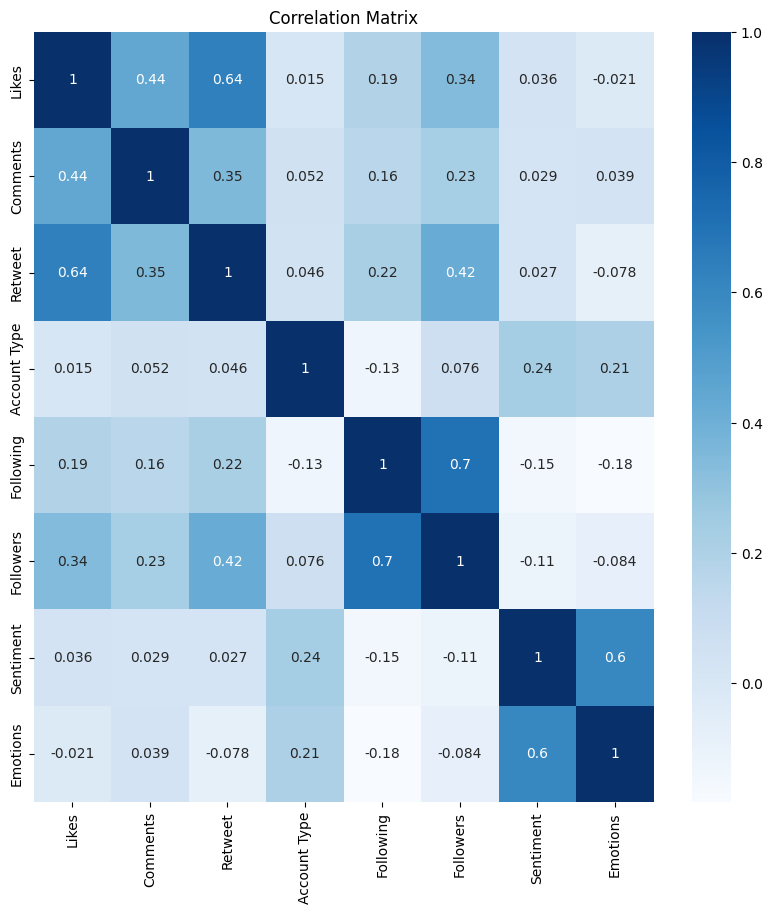

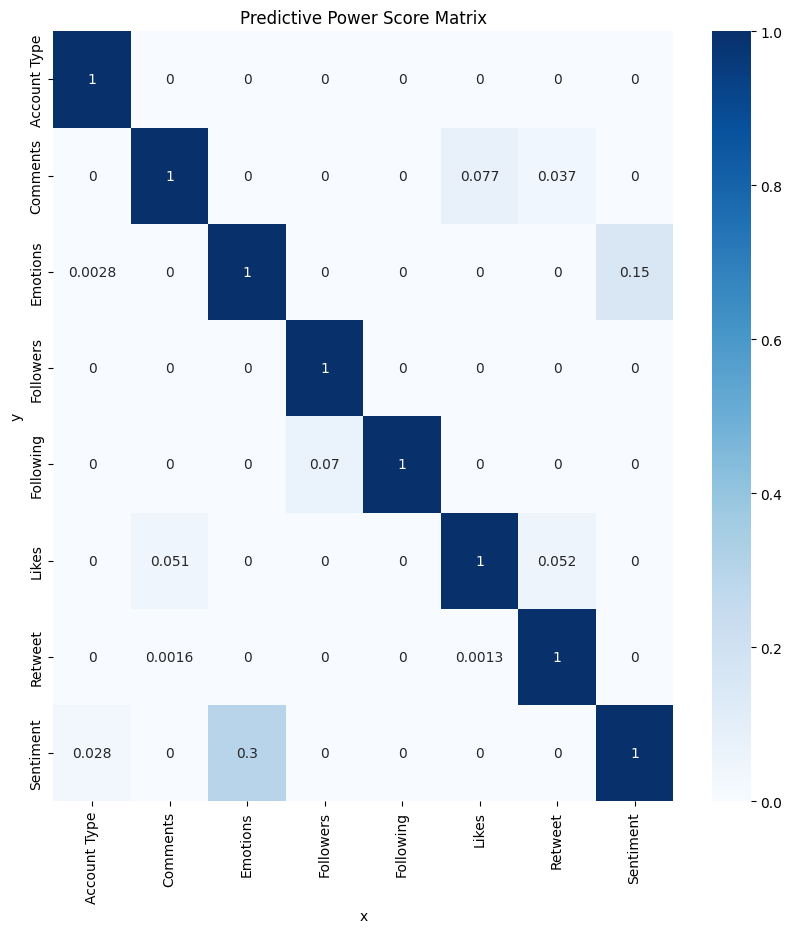

In [6]:
#consp corr and pps
dfconsp_corr = dfconsp.drop(['Tweet','emotions_string', 'Annotation'],axis=1)
correlationconsp=dfconsp_corr.corr(method='spearman')
plt.figure(figsize=(10, 10))
dataplot = sns.heatmap(dfconsp_corr.corr(method='spearman'), cmap='Blues' ,annot=True)
plt.title("Correlation Matrix")
plt.show()
plt.figure(figsize=(10, 10))
matrix_dfconsp = pps.matrix(dfconsp_corr)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_dfconsp, cmap="Blues", annot=True)
plt.title("Predictive Power Score Matrix")
plt.show()

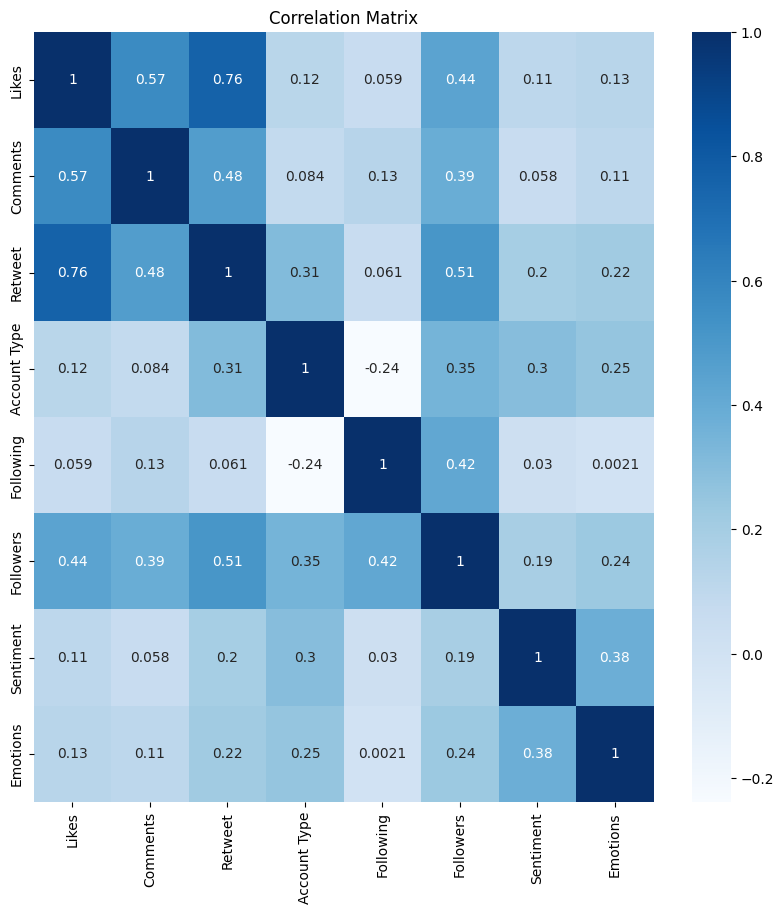

Text(0.5, 1.0, 'Predictive Power Score Matrix')

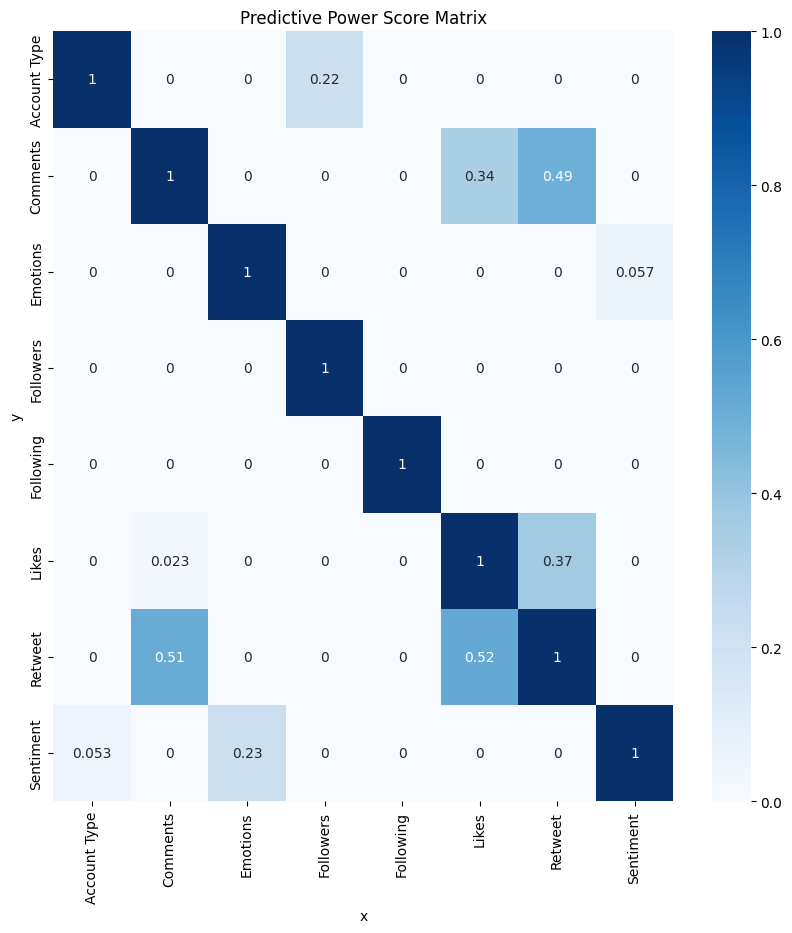

In [7]:
#consp corr and pps
dftrue_corr = dftrue.drop(['Tweet','emotions_string', 'Annotation'],axis=1)
correlationtrue=dftrue_corr.corr(method='spearman')
plt.figure(figsize=(10, 10))
dataplottrue = sns.heatmap(dftrue_corr.corr(method='spearman'), cmap='Blues' ,annot=True)
plt.title("Correlation Matrix")
plt.show()
plt.figure(figsize=(10, 10))
matrix_dftrue = pps.matrix(dftrue_corr)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_dftrue, cmap="Blues", annot=True)
plt.title("Predictive Power Score Matrix")

In [8]:
#correlation
df_corr = df.drop(['Tweet','emotions_string', 'Annotation'],axis=1)
correlation=df_corr.corr(method='spearman')

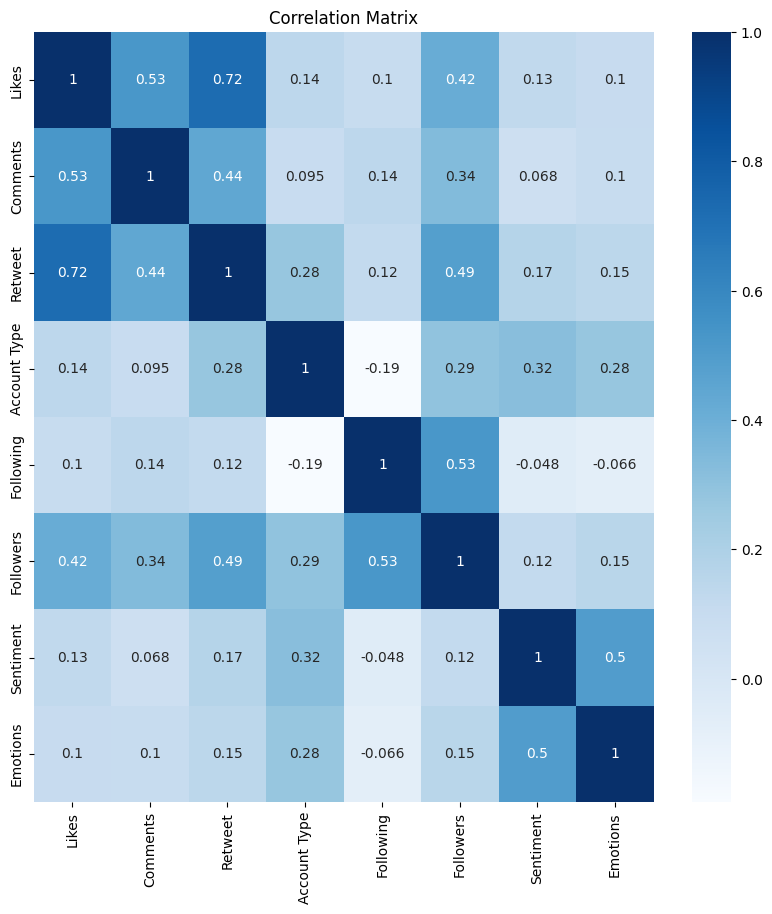

In [9]:
#correlation matrix
plt.figure(figsize=(10, 10))
dataplot = sns.heatmap(df_corr.corr(method='spearman'), cmap='Blues' ,annot=True)
plt.title("Correlation Matrix")
plt.show()


In [10]:
#pps
pps_matrix=pps.matrix(df_corr)

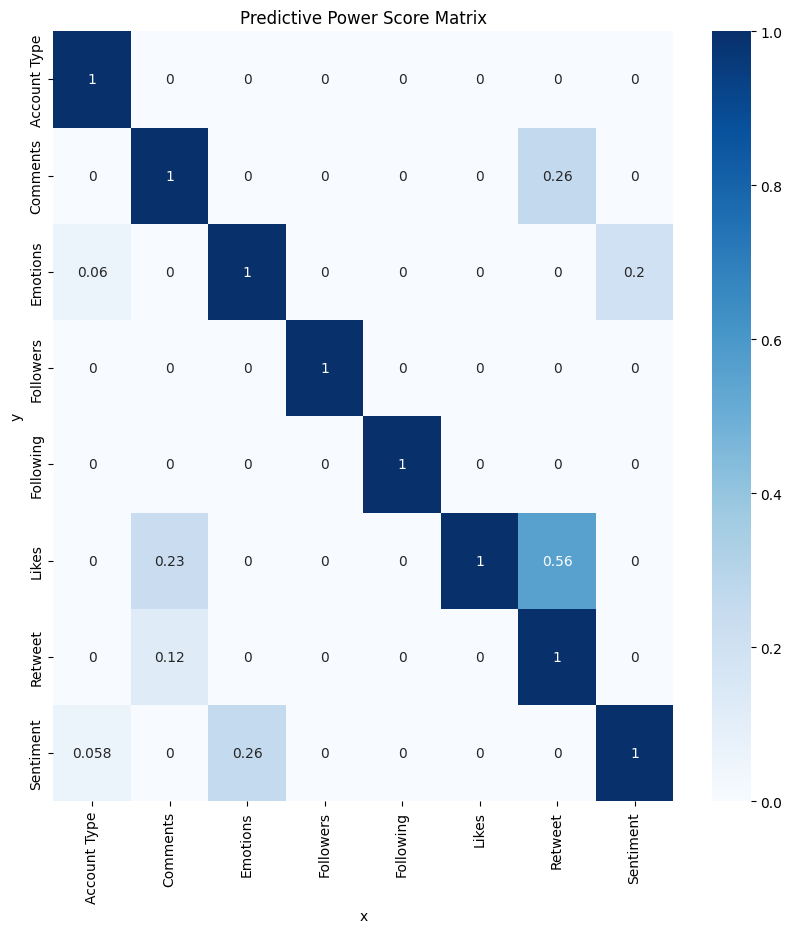

In [11]:
#pps matrix
plt.figure(figsize=(10, 10))
matrix_df = pps.matrix(df_corr)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, cmap="Blues", annot=True)
plt.title("Predictive Power Score Matrix")
plt.show()

In [12]:
#descriptive figures


annotation_labels = {0: "True Information", 1: "Conspiracy Theory"}
df['Annotation'] = df['Annotation'].map(annotation_labels)
emotion_labels = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Joy",
    4: "Neutral",
    5: "Sadness",
    6: "Surprise"
}
df['Emotions'] = df['Emotions'].map(emotion_labels)

account_labels = {0: "Private", 1: "Media",2:"Bot"}
df['Account Type'] = df['Account Type'].map(account_labels)


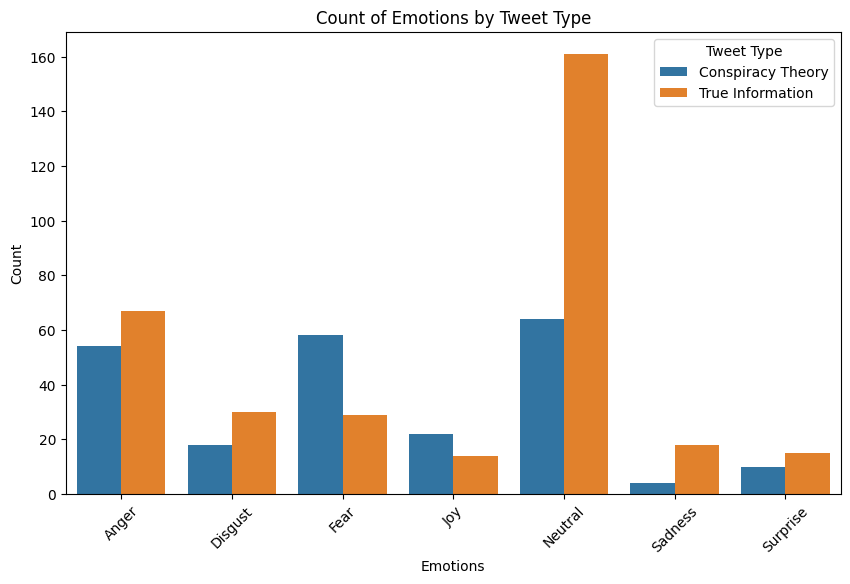

In [13]:
#distribution of emotions by tweet type

emotion_count_by_annotation = df.groupby(['Annotation', 'Emotions'])['Tweet'].count().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Emotions', y='Tweet', hue='Annotation', data=emotion_count_by_annotation)

plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Count of Emotions by Tweet Type')

plt.legend(title='Tweet Type', loc='upper right')
plt.xticks(rotation=45)
plt.show()

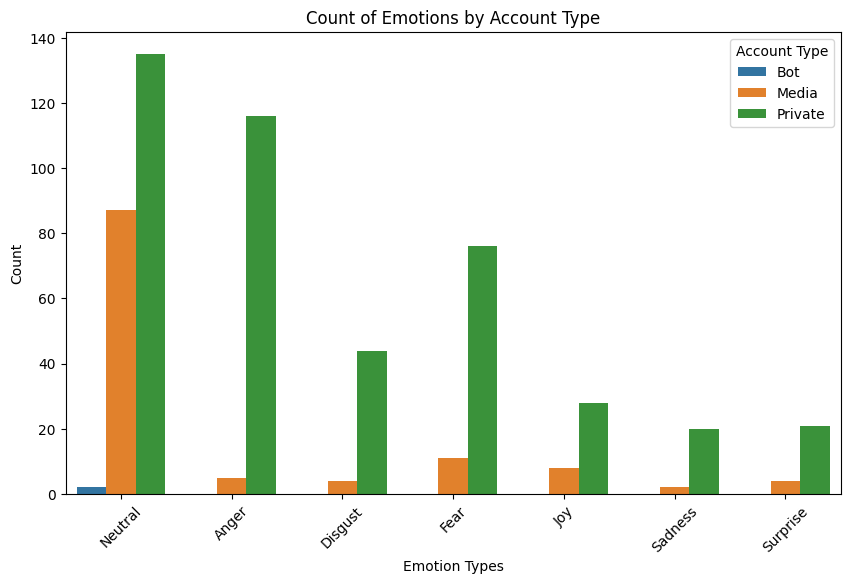

In [14]:
#distribution of emotions by account type

emotion_count_by_account = df.groupby(['Account Type', 'Emotions'])['Tweet'].count().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Emotions', y='Tweet', hue='Account Type', data=emotion_count_by_account)

plt.xlabel('Emotion Types')
plt.ylabel('Count')
plt.title('Count of Emotions by Account Type')
plt.legend(title='Account Type', loc='upper right')
plt.xticks(rotation=45)
plt.show()

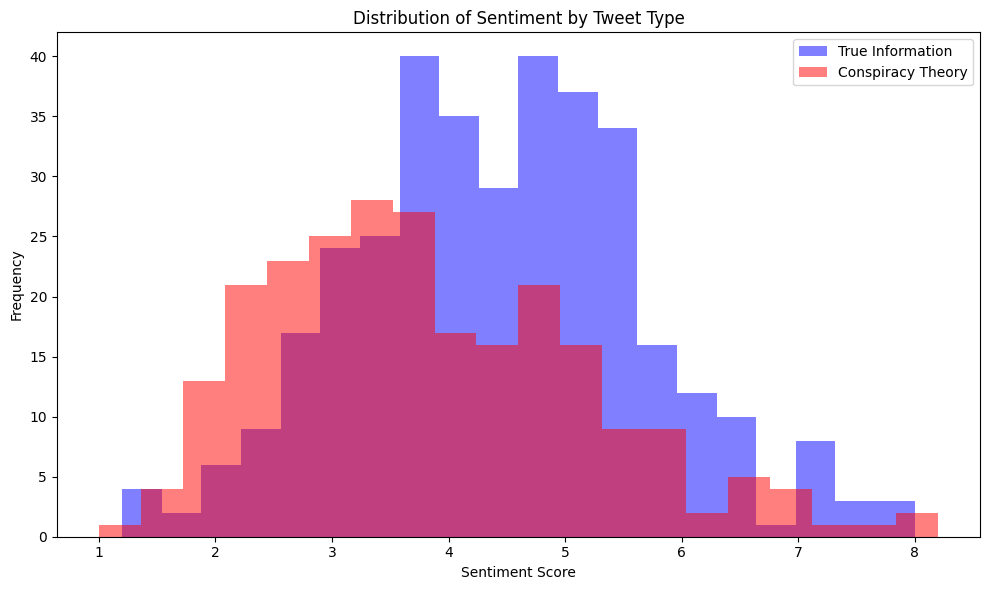

In [15]:
#sentiment score by tweet type histogram
grouped_data_hist = df.groupby('Annotation')['Sentiment'].apply(list)

plt.figure(figsize=(10, 6))

# Plot histogram for True Information
plt.hist(grouped_data_hist['True Information'], bins=20, alpha=0.5, label='True Information', color='blue')

# Plot histogram for Conspiracy Theory
plt.hist(grouped_data_hist['Conspiracy Theory'], bins=20, alpha=0.5, label='Conspiracy Theory', color='red')

# Add labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment by Tweet Type')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


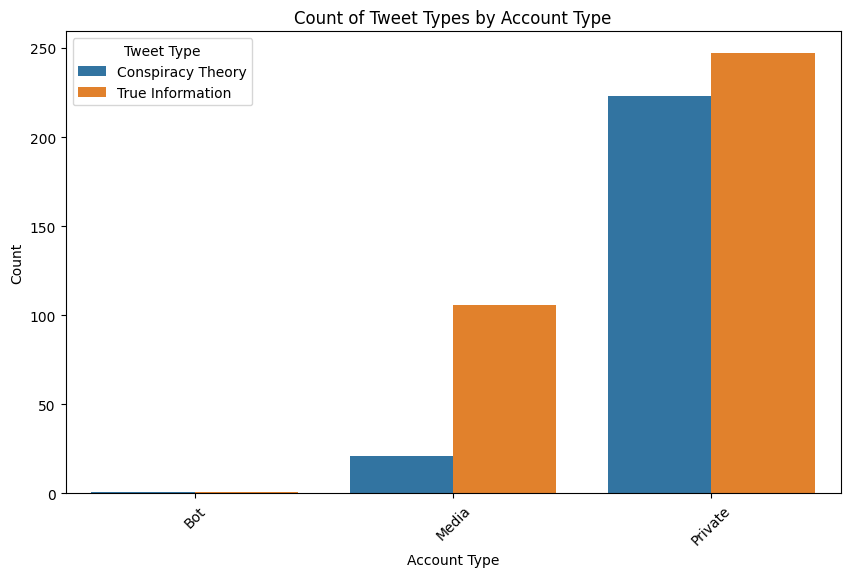

In [16]:
#distribution of tweet type by account type
account_count_by_annotation = df.groupby(['Account Type', 'Annotation'])['Tweet'].count().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Account Type', y='Tweet', hue='Annotation', data=account_count_by_annotation)

plt.xlabel('Account Type')
plt.ylabel('Count')
plt.title('Count of Tweet Types by Account Type')
plt.legend(title='Tweet Type', loc='upper left')
plt.xticks(rotation=45)
plt.show()

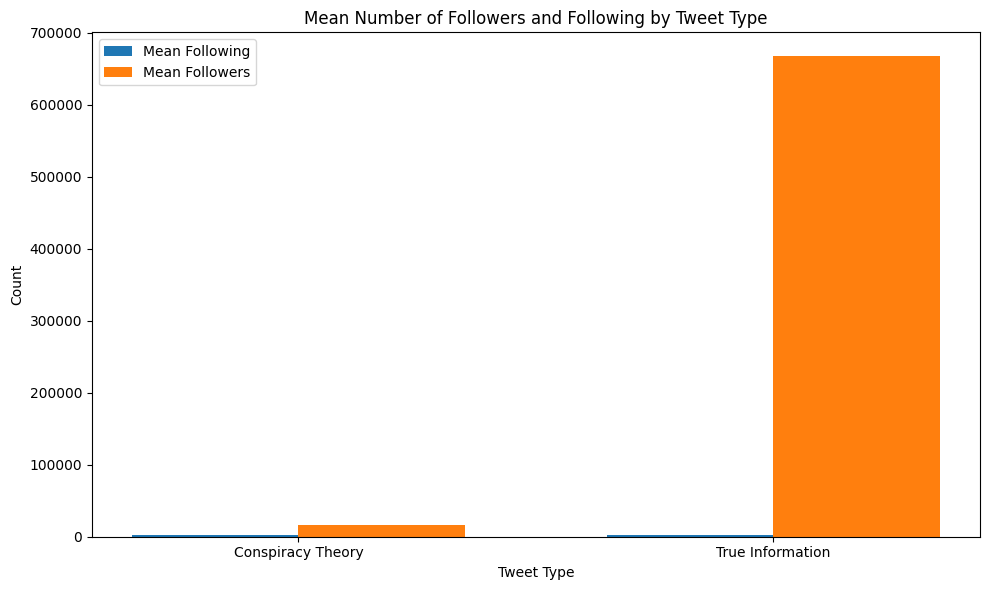

In [17]:
#mean no of followers and following by tweet type
grouped_data_follow = df.groupby('Annotation').agg({
    'Following': 'mean',
    'Followers': 'mean'
}).reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))

# Positions for the bars
positions2 = range(len(grouped_data_follow))

# Width of the bars
width = 0.35

# Plot mean following
plt.bar(positions2, grouped_data_follow['Following'], width, label='Mean Following')

# Plot mean followers
plt.bar([pos + width for pos in positions2], grouped_data_follow['Followers'], width, label='Mean Followers')

# Add labels and title
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.title('Mean Number of Followers and Following by Tweet Type')
plt.xticks([pos + width / 2 for pos in positions2], grouped_data_follow['Annotation'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

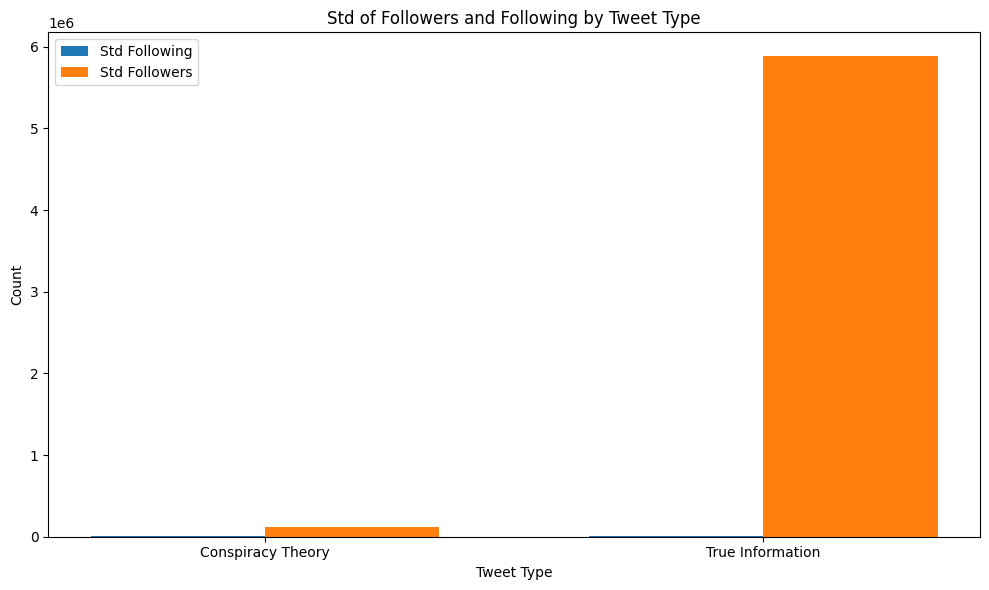

In [18]:
#std of following followers by tweet type
grouped_data_follow2 = df.groupby('Annotation').agg({
    'Following': 'std',
    'Followers': 'std'
}).reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))

# Positions for the bars
positions3 = range(len(grouped_data_follow2))

# Width of the bars
width = 0.35

# Plot mean following
plt.bar(positions3, grouped_data_follow2['Following'], width, label='Std Following')

# Plot mean followers
plt.bar([pos + width for pos in positions3], grouped_data_follow2['Followers'], width, label='Std Followers')

# Add labels and title
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.title('Std of Followers and Following by Tweet Type')
plt.xticks([pos + width / 2 for pos in positions3], grouped_data_follow2['Annotation'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

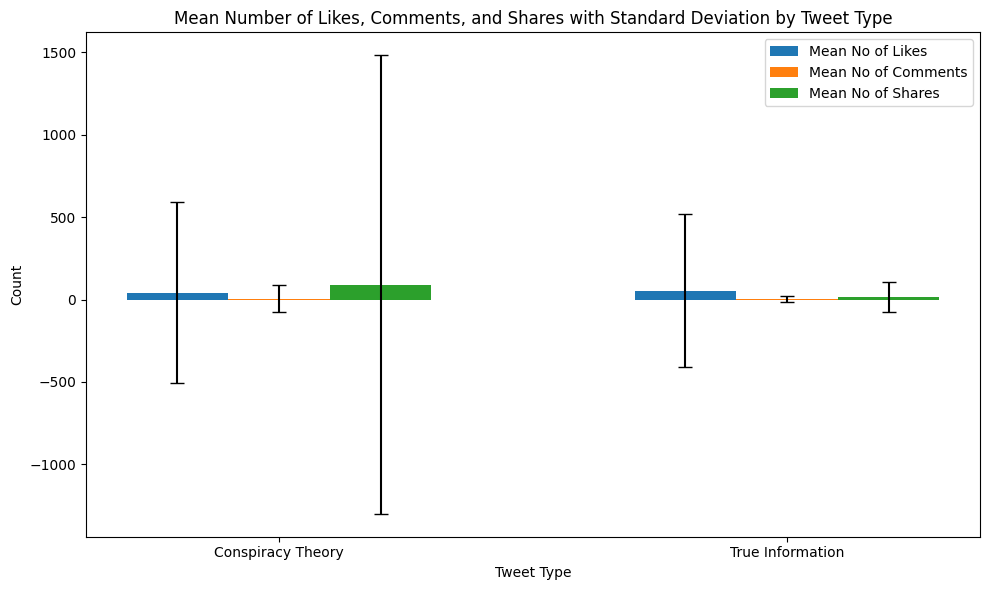

In [19]:
#mean no of comment, like, retweet by tweet type
grouped_data_likes = df.groupby('Annotation').agg({
    'Likes': ['mean', 'std'],
    'Comments': ['mean', 'std'],
    'Retweet': ['mean', 'std']
}).reset_index()

grouped_data_likes.columns = ['Annotation', 
                        'Mean Likes', 'Std Likes',
                        'Mean Comments', 'Std Comments',
                        'Mean Shares', 'Std Shares']

plt.figure(figsize=(10, 6))

positions = range(len(grouped_data_likes))

width = 0.2

plt.bar(positions, grouped_data_likes['Mean Likes'], width, yerr=grouped_data_likes['Std Likes'],
        capsize=5, label='Mean No of Likes')

plt.bar([pos + width for pos in positions], grouped_data_likes['Mean Comments'], width, yerr=grouped_data_likes['Std Comments'],
        capsize=5, label='Mean No of Comments')

plt.bar([pos + 2 * width for pos in positions], grouped_data_likes['Mean Shares'], width, yerr=grouped_data_likes['Std Shares'],
        capsize=5, label='Mean No of Shares')

plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.title('Mean Number of Likes, Comments, and Shares with Standard Deviation by Tweet Type')
plt.xticks([pos + width for pos in positions], grouped_data_likes['Annotation'])
plt.legend()

plt.tight_layout()
plt.show()

/var/folders/19/r6p2mx9n4rq61jqxmlt1qrd40000gn/T/ipykernel_18091/4132218689.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['emotions_string'] = df_cleaned['emotions_string'].apply(lambda x: re.sub(r'[^\w\s]', '', x))


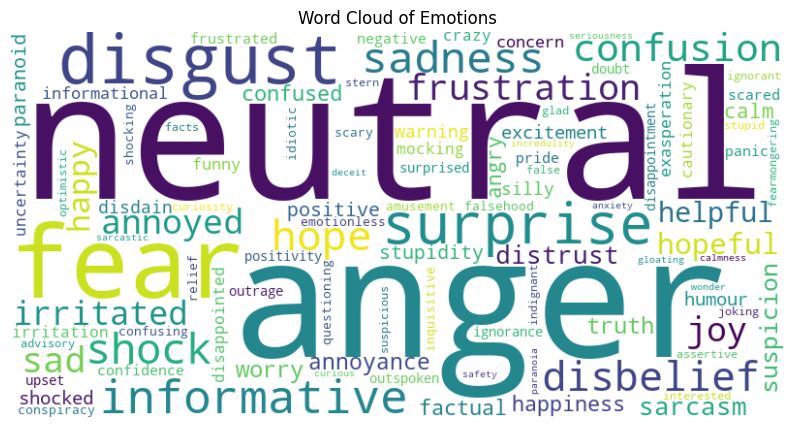

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [20]:
#word map of emotions
df_cleaned = df.dropna(subset=['emotions_string'])

df_cleaned['emotions_string'] = df_cleaned['emotions_string'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

word_frequencies = Counter(' '.join(df_cleaned['emotions_string']).split())

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, prefer_horizontal=0.9, mask=None).generate_from_frequencies(word_frequencies)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Emotions')
plt.show()

#word cloud for true info
df_cleaned_true=df_cleaned[df_cleaned['Annotation']==0]
word_frequencies_true = Counter(' '.join(df_cleaned_true['emotions_string']).split())

wordcloud_true = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, prefer_horizontal=0.9, mask=None).generate_from_frequencies(word_frequencies_true)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Emotions for True Information')
plt.show()

#word cloud for conspiracy info
df_cleaned_consp=df_cleaned[df_cleaned['Annotation']==1]
word_frequencies_consp = Counter(' '.join(df_cleaned_consp['emotions_string']).split())

wordcloud_consp = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=100, prefer_horizontal=0.9, mask=None).generate_from_frequencies(word_frequencies_consp)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_consp, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Emotions for Conspiracy Theories')
plt.show()

In [ ]:
# no of unique sentiments/emotions
print(df['Sentiment Type'].value_counts())
print(df['Emotions'].value_counts())
print(df['Emotions'].notna().sum())
condition1=df['Annotation']==0
condition2=df['Annotation']==1
print(df[condition1]['Emotions'].notna().sum())
print(df[condition2]['Emotions'].notna().sum())
#print(df[condition1]['Emotions'].value_counts())
print(df[condition2]['Emotions'].value_counts())

 0.0    276
-1.0    269
 1.0     55
Name: Sentiment Type, dtype: int64
4.0    225
0.0    121
2.0     87
1.0     48
3.0     36
6.0     25
5.0     22
Name: Emotions, dtype: int64
564
334
230
4.0    64
2.0    58
0.0    54
3.0    22
1.0    18
6.0    10
5.0     4
Name: Emotions, dtype: int64


In [21]:
#sentiment prediction
annotation_labels_rev = {"True Information":0, "Conspiracy Theory":1}
df['Annotation'] = df['Annotation'].map(annotation_labels_rev)
emotion_labels_rev = {
    "Anger":0,
    "Disgust":1,
    "Fear":2,
    "Joy":3,
    "Neutral":4,
    "Sadness":5,
    "Surprise":6
}
df['Emotions'] = df['Emotions'].map(emotion_labels_rev)

account_labels_rev = {"Private":0, "Media":1,"Bot":2}
df['Account Type'] = df['Account Type'].map(account_labels_rev)

df['Sentiment']=df['Sentiment']/10

In [22]:
#sentiment type
df['Sentiment Type'] = np.select(
    condlist=[
        (df['Sentiment'] >= 0) & (df['Sentiment'] < 0.4),
        (df['Sentiment'] >= 0.4) & (df['Sentiment'] < 0.6),
        (df['Sentiment'] >= 0.6) & (df['Sentiment'] <= 1)
    ],
    choicelist=[-1, 0, 1],
    default=np.nan
)

annotation_labels = {0: "True Information", 1: "Conspiracy Theory"}
df['Annotation'] = df['Annotation'].map(annotation_labels)

# Map the Sentiment_Recoded labels
sentiment_labels = {-1: "Negative", 0: "Neutral", 1: "Positive"}
df['Sentiment Type'] = df['Sentiment Type'].map(sentiment_labels)

# Group the data by Annotation and Sentiment_Recoded and calculate the count
grouped_data = df.groupby(['Annotation', 'Sentiment Type'])['Sentiment Type'].count().unstack(fill_value=0)

# Plot the bar chart
plt.figure(figsize=(10, 6))

# Positions for the bars
positions4 = range(len(grouped_data))

# Width of the bars
width = 0.35

# Plot Negative
plt.bar(positions4, grouped_data['Negative'], width, label='Negative', color='red')

# Plot Neutral
plt.bar(positions4, grouped_data['Neutral'], width, bottom=grouped_data['Negative'], label='Neutral', color='blue')

# Plot Positive
plt.bar(positions4, grouped_data['Positive'], width, bottom=grouped_data['Negative'] + grouped_data['Neutral'], label='Positive', color='green')

# Add labels and title
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.title('Count of Sentiment Type by Tweet Type')
plt.xticks(positions4, grouped_data.index)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [20]:
#vader
analyser = SentimentIntensityAnalyzer()
scores=[]
for i in range(len(df['Tweet'])):
    score = analyser.polarity_scores(df['Tweet'][i])
    score=score['compound']
    scores.append(score)
sentiment_vader=[]
for i in scores:
    if i>=0.2:
        sentiment_vader.append(1)
    elif i<=(-0.2):
        sentiment_vader.append(-1)
    else:
        sentiment_vader.append(0)
df['Sentiment Vader']=pd.Series(np.array(sentiment_vader))


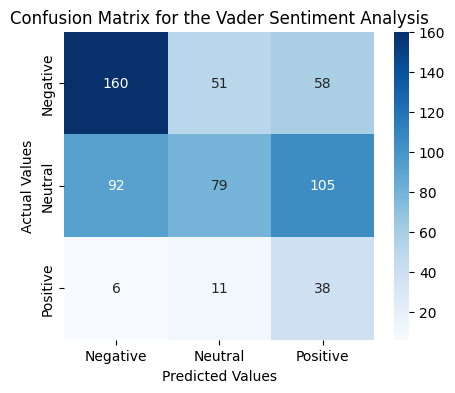

              precision    recall  f1-score   support

    Negative       0.62      0.59      0.61       269
     Neutral       0.56      0.29      0.38       276
    Positive       0.19      0.69      0.30        55

    accuracy                           0.46       600
   macro avg       0.46      0.52      0.43       600
weighted avg       0.55      0.46      0.47       600



In [21]:
#overall performance
cm_vader=confusion_matrix(df['Sentiment Type'],df['Sentiment Vader'])
cm_vader_df = pd.DataFrame(cm_vader,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_vader_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the Vader Sentiment Analysis')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df['Sentiment Type'],df['Sentiment Vader'], target_names=['Negative','Neutral','Positive']))

Data for True Information


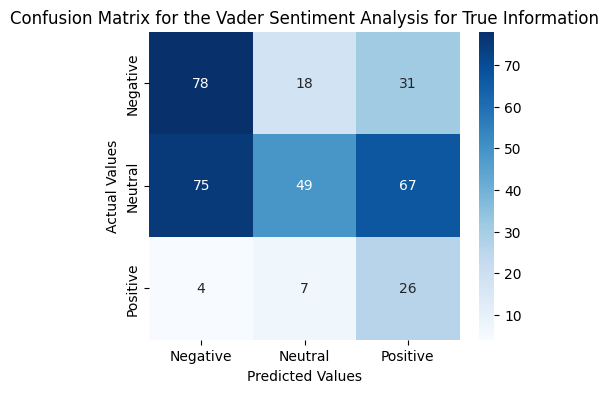

              precision    recall  f1-score   support

    Negative       0.50      0.61      0.55       127
     Neutral       0.66      0.26      0.37       191
    Positive       0.21      0.70      0.32        37

    accuracy                           0.43       355
   macro avg       0.46      0.52      0.41       355
weighted avg       0.56      0.43      0.43       355

Data for Conspiracy Theory


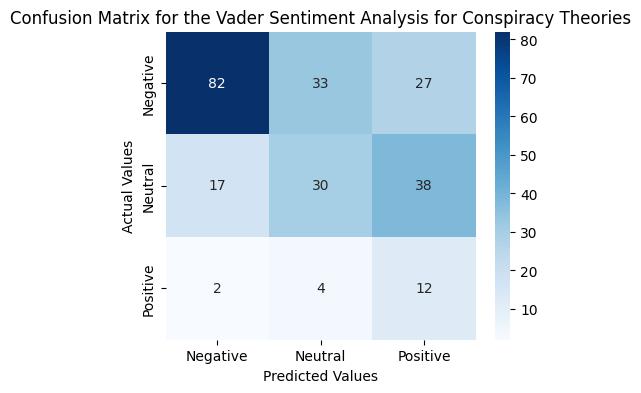

              precision    recall  f1-score   support

    Negative       0.81      0.58      0.67       142
     Neutral       0.45      0.35      0.39        85
    Positive       0.16      0.67      0.25        18

    accuracy                           0.51       245
   macro avg       0.47      0.53      0.44       245
weighted avg       0.64      0.51      0.55       245



In [22]:
#performance by tweet type
df_true=df[df['Annotation']==0]
df_consp=df[df['Annotation']==1]
print("Data for True Information")
cm_vader_true=confusion_matrix(df_true['Sentiment Type'],df_true['Sentiment Vader'])
cm_vader_true_df = pd.DataFrame(cm_vader_true,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_vader_true_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the Vader Sentiment Analysis for True Information')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df_true['Sentiment Type'],df_true['Sentiment Vader'], target_names=['Negative','Neutral','Positive']))
print("Data for Conspiracy Theory")
cm_vader_consp=confusion_matrix(df_consp['Sentiment Type'],df_consp['Sentiment Vader'])
cm_vader_consp_df = pd.DataFrame(cm_vader_consp,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_vader_consp_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the Vader Sentiment Analysis for Conspiracy Theories')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df_consp['Sentiment Type'],df_consp['Sentiment Vader'], target_names=['Negative','Neutral','Positive']))

In [23]:
#ML model for sentiment
sentiment_task = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest")
sentiment_classifier=[]
for tweet in df['Tweet']:
    x=sentiment_task(tweet)
    sentiment_classifier.append(x[0]['label'])
print(sentiment_classifier)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['positive', 'negative', 'neutral', 'negative', 'neutral', 'negative', 'neutral', 'negative', 'negative', 'negative', 'neutral', 'neutral', 'negative', 'negative', 'neutral', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'neutral', 'neutral', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'neutral', 'negative', 'negative', 'neutral', 'neutral', 'negative', 'negative', 'negative', 'negative', 'negative', 'neutral', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'neutral', 'negative', 'negative', 'neutral', 'negative', 'negative', 'neutral', 'negative', 'neutral', 'negative', 'negative', 'neutral', 'negative', 'negative', 'positive', 'negative', 'neutral', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'neutral', 'negative', 'negative'

In [24]:
df['Sentiment ML']=pd.Series(np.array(sentiment_classifier))
sentiment_ml={
    'positive':1,
    'neutral':0,
    'negative':-1
}
df['Sentiment ML'] = df['Sentiment ML'].map(sentiment_ml)

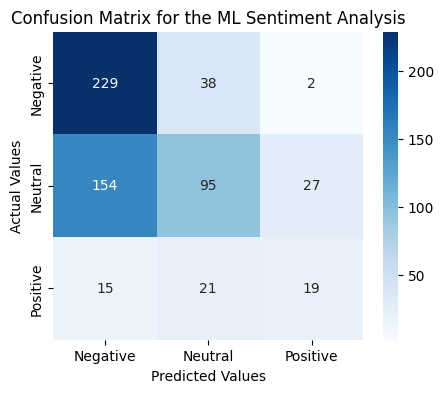

              precision    recall  f1-score   support

    Negative       0.58      0.85      0.69       269
     Neutral       0.62      0.34      0.44       276
    Positive       0.40      0.35      0.37        55

    accuracy                           0.57       600
   macro avg       0.53      0.51      0.50       600
weighted avg       0.58      0.57      0.54       600



In [25]:
#overall performance
cm_ml=confusion_matrix(df['Sentiment Type'],df['Sentiment ML'])
cm_ml_df = pd.DataFrame(cm_ml,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_ml_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the ML Sentiment Analysis')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df['Sentiment Type'],df['Sentiment ML'], target_names=['Negative','Neutral','Positive']))


Data for True Information


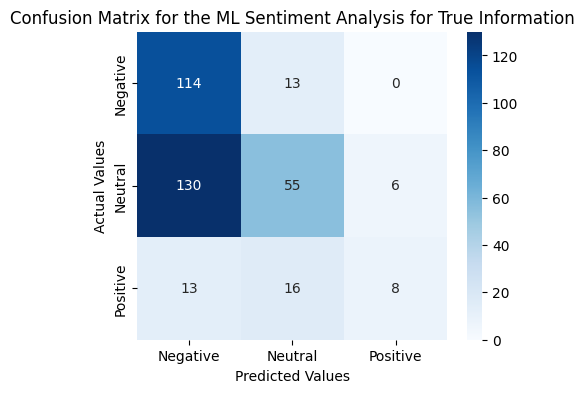

              precision    recall  f1-score   support

    Negative       0.44      0.90      0.59       127
     Neutral       0.65      0.29      0.40       191
    Positive       0.57      0.22      0.31        37

    accuracy                           0.50       355
   macro avg       0.56      0.47      0.44       355
weighted avg       0.57      0.50      0.46       355

Data for Conspiracy Theory


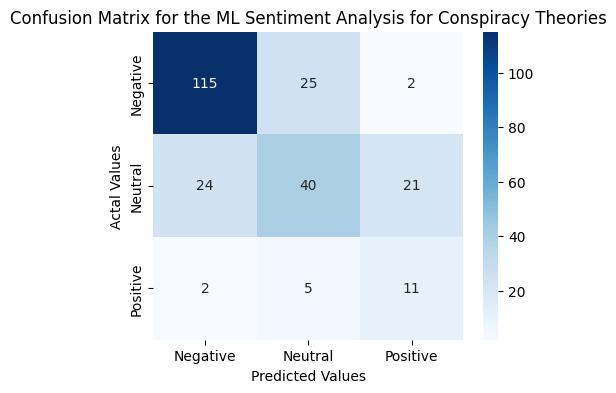

              precision    recall  f1-score   support

    Negative       0.82      0.81      0.81       142
     Neutral       0.57      0.47      0.52        85
    Positive       0.32      0.61      0.42        18

    accuracy                           0.68       245
   macro avg       0.57      0.63      0.58       245
weighted avg       0.69      0.68      0.68       245



In [26]:
#per class
df_true_ml=df[df['Annotation']==0]
df_consp_ml=df[df['Annotation']==1]
print("Data for True Information")
cm_ml_true=confusion_matrix(df_true_ml['Sentiment Type'],df_true_ml['Sentiment ML'])
cm_ml_true_df = pd.DataFrame(cm_ml_true,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_ml_true_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the ML Sentiment Analysis for True Information')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df_true_ml['Sentiment Type'],df_true_ml['Sentiment ML'], target_names=['Negative','Neutral','Positive']))
print("Data for Conspiracy Theory")
cm_ml_consp=confusion_matrix(df_consp_ml['Sentiment Type'],df_consp_ml['Sentiment ML'])
cm_ml_consp_df = pd.DataFrame(cm_ml_consp,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_ml_consp_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the ML Sentiment Analysis for Conspiracy Theories')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df_consp_ml['Sentiment Type'],df_consp_ml['Sentiment ML'], target_names=['Negative','Neutral','Positive']))


In [19]:
#fine tuning roberta


,Annotation,Tweet,Likes,Comments,Retweet,Account Type,Following,Followers,Sentiment,Emotions,emotions_string,Sentiment Type
0,0,People urgently need reliable and accurate inf...,1756,135,650,0.0,1873,1959628,0.740,3.0,"reliability, determined,",1.0
1,0,"If any of y’all think coronavirus is “gone,” o...",7,0,3,0.0,148,65,0.240,1.0,"anger, disgust, hostile",-1.0
2,0,Facebook will start steering users who interac...,0,0,1,0.0,3101,9323,0.540,4.0,"neutral, information",0.0
3,0,I sure hope this survey was anonymous. 4 perce...,0,0,0,0.0,666,930,0.360,1.0,"disgust, disbelief",-1.0
4,1,Q'd Drop Doctor speaks about hydroxychloroquin...,1,0,0,0.0,756,1339,0.480,4.0,neutral,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
595,1,Do a search for Dr Richard Bartlett on Youtube...,0,0,0,0.0,471,430,0.700,3.0,"hope, disgust",1.0
596,1,A friend sent us this interview with an ER Doc...,0,0,0,1.0,1723,310,0.425,3.0,"sad, hope",0.0
597,0,"No, 5G radiation doesn't cause or spread the #...",48,4,24,0.0,5982,88405,0.700,2.0,"stern, annoyance, joy",1.0
598,0,"You took it for ""malaria prevention."" Which i...",3,0,1,0.0,379,466,0.325,0.0,"anger, irritated, fear, interested, paranoid",-1.0


In [140]:
#preprocessing
stop_words=set(nltk.corpus.stopwords.words('english'))
punctuation=set(string.punctuation)
df['Tweet Processes'] = df['Tweet'].apply(lambda text: " ".join([token for token in nltk.tokenize.word_tokenize(text.lower())
                           if token not in stop_words and token not in punctuation]))

In [177]:
df1=df[0:500]
df1['Sentiment Type'] = df['Sentiment Type'].map({1: 2, 0: 1, -1:0})
reviews = df1['Tweet Processes'].tolist()
labels = df1['Sentiment Type'].tolist()
train_texts, val_texts, train_labels, val_labels = train_test_split(reviews, labels, test_size=0.2)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)


# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)
for epoch in range(5):  # number of epochs
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
model.save_pretrained('sentiment_model_RoBERTa')


/var/folders/19/r6p2mx9n4rq61jqxmlt1qrd40000gn/T/ipykernel_5022/3957690831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Sentiment Type'] = df['Sentiment Type'].map({1: 2, 0: 1, -1:0})
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [178]:

# Load the model
model = RobertaForSequenceClassification.from_pretrained('sentiment_model_RoBERTa')

# Load validation data
val_data = df[500::]
val_texts = val_data['Tweet Processes'].tolist()
val_labels = val_data['Sentiment Type'].map({1: 2, 0: 1, -1:0}).tolist() 

# Initialize tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenize data
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Create torch dataset for validation
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

val_dataset = ReviewDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Evaluate the model
model.eval()
predictions = []
true_labels = []
for batch in val_loader:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.extend(predicted_labels)
    true_labels.extend(labels.cpu().numpy())

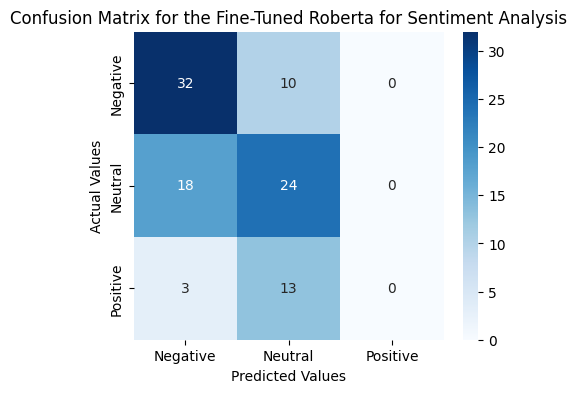

              precision    recall  f1-score   support

    Negative       0.60      0.76      0.67        42
     Neutral       0.51      0.57      0.54        42
    Positive       0.00      0.00      0.00        16

    accuracy                           0.56       100
   macro avg       0.37      0.44      0.40       100
weighted avg       0.47      0.56      0.51       100



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [179]:
#fine tuned roberta overall

cm_ft=confusion_matrix(true_labels,predictions)
cm_ft_df = pd.DataFrame(cm_ft,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_ft_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the Fine-Tuned Roberta for Sentiment Analysis')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(true_labels,predictions, target_names=['Negative','Neutral','Positive']))

In [147]:

val_data['Sentiment FT']=predictions
sentiment_ft={
    2:1,
    1:0,
    0:-1
}
val_data['Sentiment FT'] = val_data['Sentiment FT'].map(sentiment_ft)
val_data

/var/folders/19/r6p2mx9n4rq61jqxmlt1qrd40000gn/T/ipykernel_5022/831679490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['Sentiment FT']=predictions
/var/folders/19/r6p2mx9n4rq61jqxmlt1qrd40000gn/T/ipykernel_5022/831679490.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['Sentiment FT'] = val_data['Sentiment FT'].map(sentiment_ft)


,Annotation,Tweet,Likes,Comments,Retweet,Account Type,Following,Followers,Sentiment,Emotions,emotions_string,Sentiment Type,Tweet Processes,Sentiment FT
500,1,Don't stand still for the imposition of martia...,3,0,1,0.0,6332,6546,0.260,0.0,"determination, outrage, scare, anger, ignorant",-1.0,n't stand still imposition martial law wuhan b...,-1
501,0,What is wrong with people? - Coronavirus canno...,0,0,0,0.0,3984,8048,0.400,6.0,"shocked, disgust, truth, irritated, exasperation",0.0,wrong people coronavirus cured drinking bleach...,0
502,1,Immune your immunity against COVID ITS EASIER ...,1,1,0,1.0,44,10,0.560,4.0,"doubt, joy, hopeful, irritated",0.0,immune immunity covid easier stay well get wel...,0
503,0,A message hailing the powers of 'boiled garlic...,2,0,0,0.0,1190,73883,0.460,4.0,"withdrawn, neutral, helpful, irritated, dunking",0.0,message hailing powers 'boiled garlic water la...,0
504,1,COVID 19 must have been created a lab. They ma...,1,0,0,0.0,2598,2075,0.320,5.0,"stubborn, neutral, deception, angry, paranoid",-1.0,covid 19 must created lab made virus intellige...,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1,Do a search for Dr Richard Bartlett on Youtube...,0,0,0,0.0,471,430,0.700,3.0,"hope, disgust",1.0,search dr richard bartlett youtube cure covid ...,0
596,1,A friend sent us this interview with an ER Doc...,0,0,0,1.0,1723,310,0.425,3.0,"sad, hope",0.0,friend sent us interview er doctor seems found...,0
597,0,"No, 5G radiation doesn't cause or spread the #...",48,4,24,0.0,5982,88405,0.700,2.0,"stern, annoyance, joy",1.0,5g radiation n't cause spread coronavirus sayi...,0
598,0,"You took it for ""malaria prevention."" Which i...",3,0,1,0.0,379,466,0.325,0.0,"anger, irritated, fear, interested, paranoid",-1.0,took `` malaria prevention '' magic coronaviru...,0


Data for True Information


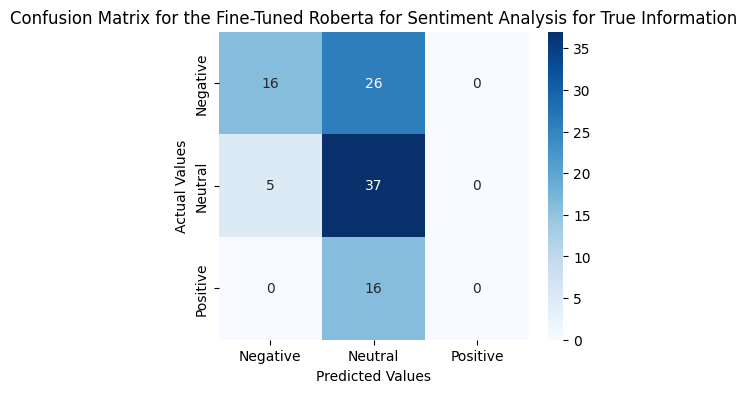

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

    Negative       0.67      0.42      0.52        19
     Neutral       0.54      0.87      0.67        31
    Positive       0.00      0.00      0.00        12

    accuracy                           0.56        62
   macro avg       0.40      0.43      0.39        62
weighted avg       0.47      0.56      0.49        62

Data for Conspiracy Theory


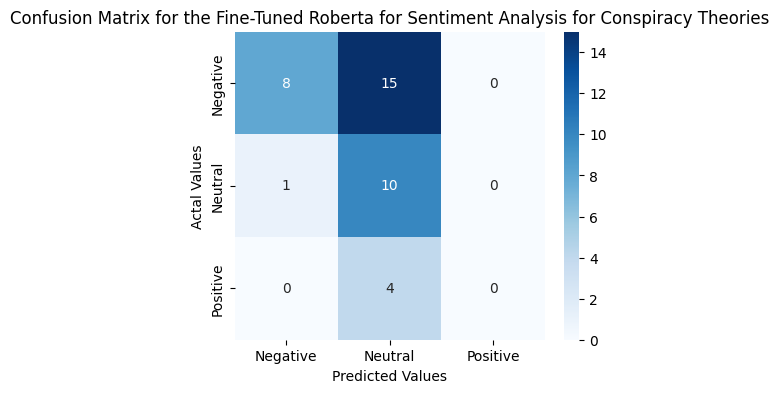

              precision    recall  f1-score   support

    Negative       0.89      0.35      0.50        23
     Neutral       0.34      0.91      0.50        11
    Positive       0.00      0.00      0.00         4

    accuracy                           0.47        38
   macro avg       0.41      0.42      0.33        38
weighted avg       0.64      0.47      0.45        38



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [148]:
#finetuned roberta per class
df_true_ft=val_data[val_data['Annotation']==0]
df_consp_ft=val_data[val_data['Annotation']==1]
print("Data for True Information")
cm_ft_true=confusion_matrix(val_data['Sentiment Type'],val_data['Sentiment FT'])
cm_ft_true_df = pd.DataFrame(cm_ft_true,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_ft_true_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the Fine-Tuned Roberta for Sentiment Analysis for True Information')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df_true_ft['Sentiment Type'],df_true_ft['Sentiment FT'], target_names=['Negative','Neutral','Positive']))
print("Data for Conspiracy Theory")
cm_ft_consp=confusion_matrix(df_consp_ft['Sentiment Type'],df_consp_ft['Sentiment FT'])
cm_ft_consp_df = pd.DataFrame(cm_ft_consp,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_ft_consp_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the Fine-Tuned Roberta for Sentiment Analysis for Conspiracy Theories')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df_consp_ft['Sentiment Type'],df_consp_ft['Sentiment FT'], target_names=['Negative','Neutral','Positive']))

In [ ]:
#emotion recognition


In [152]:
#NRCLex
NCLex_scores=[]
NRCLex(df['Tweet'][0]).top_emotions[0][0]
for i in range(len(df['Tweet'])):
    score_NRCLex = NRCLex(df['Tweet'][i]).top_emotions[0][0]
    NCLex_scores.append(score_NRCLex)
df['NRCLex']=pd.Series(np.array(NCLex_scores))
emotion_labels_NRCLex = {
    "anger":0,
    "disgust":1,
    "fear":2,
    "joy":3,
    "anticipation":4,
    "sadness":5,
    "surprise":6,
    "trust":4,
    "negative":4,
    "positive":4
}
df['NRCLex'] = df['NRCLex'].map(emotion_labels_NRCLex)
df

,Annotation,Tweet,Likes,Comments,Retweet,Account Type,Following,Followers,Sentiment,Emotions,emotions_string,Sentiment Type,Tweet Processes,NRCLex
0,0,People urgently need reliable and accurate inf...,1756,135,650,0.0,1873,1959628,0.740,3.0,"reliability, determined,",1.0,people urgently need reliable accurate informa...,4
1,0,"If any of y’all think coronavirus is “gone,” o...",7,0,3,0.0,148,65,0.240,1.0,"anger, disgust, hostile",-1.0,’ think coronavirus “ gone ” fake flu please s...,4
2,0,Facebook will start steering users who interac...,0,0,1,0.0,3101,9323,0.540,4.0,"neutral, information",0.0,facebook start steering users interact coronav...,4
3,0,I sure hope this survey was anonymous. 4 perce...,0,0,0,0.0,666,930,0.360,1.0,"disgust, disbelief",-1.0,sure hope survey anonymous 4 percent people su...,2
4,1,Q'd Drop Doctor speaks about hydroxychloroquin...,1,0,0,0.0,756,1339,0.480,4.0,neutral,0.0,q 'd drop doctor speaks hydroxychloroquine zin...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1,Do a search for Dr Richard Bartlett on Youtube...,0,0,0,0.0,471,430,0.700,3.0,"hope, disgust",1.0,search dr richard bartlett youtube cure covid ...,2
596,1,A friend sent us this interview with an ER Doc...,0,0,0,1.0,1723,310,0.425,3.0,"sad, hope",0.0,friend sent us interview er doctor seems found...,4
597,0,"No, 5G radiation doesn't cause or spread the #...",48,4,24,0.0,5982,88405,0.700,2.0,"stern, annoyance, joy",1.0,5g radiation n't cause spread coronavirus sayi...,4
598,0,"You took it for ""malaria prevention."" Which i...",3,0,1,0.0,379,466,0.325,0.0,"anger, irritated, fear, interested, paranoid",-1.0,took `` malaria prevention '' magic coronaviru...,4


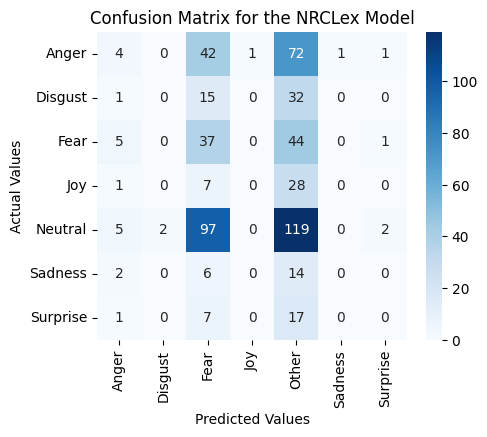

              precision    recall  f1-score   support

       Anger       0.21      0.03      0.06       121
     Disgust       0.00      0.00      0.00        48
        Fear       0.18      0.43      0.25        87
         Joy       0.00      0.00      0.00        36
     Neutral       0.37      0.53      0.43       225
     Sadness       0.00      0.00      0.00        22
    Surprise       0.00      0.00      0.00        25

    accuracy                           0.28       564
   macro avg       0.11      0.14      0.11       564
weighted avg       0.22      0.28      0.22       564



In [153]:
#overall performance
df1_NRC=df.dropna(subset=['Emotions'])
cm_class1_NRC=confusion_matrix(df1_NRC['Emotions'],df1_NRC['NRCLex'])
cm_class1_df_NRC = pd.DataFrame(cm_class1_NRC,
                     index = ['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise'], 
                     columns = ['Anger','Disgust','Fear','Joy','Other','Sadness','Surprise'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_class1_df_NRC, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the NRCLex Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df1_NRC['Emotions'],df1_NRC['NRCLex'], target_names=['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise']))

Data for True Information


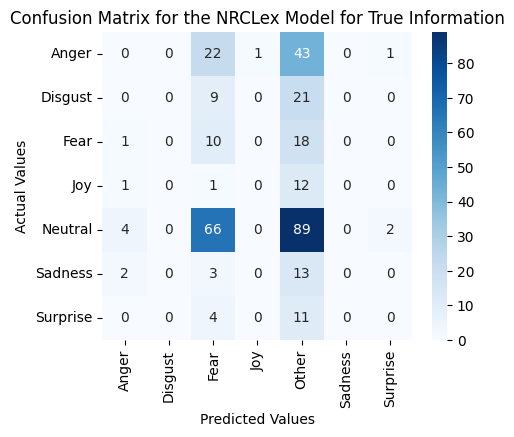

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        67
     Disgust       0.00      0.00      0.00        30
        Fear       0.09      0.34      0.14        29
         Joy       0.00      0.00      0.00        14
     Neutral       0.43      0.55      0.48       161
     Sadness       0.00      0.00      0.00        18
    Surprise       0.00      0.00      0.00        15

    accuracy                           0.30       334
   macro avg       0.07      0.13      0.09       334
weighted avg       0.21      0.30      0.25       334

Data for Conspiracy Theory


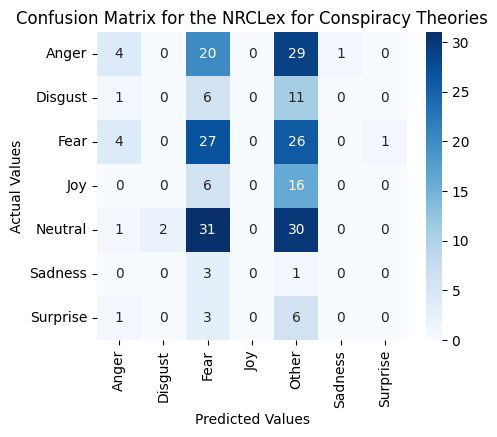

              precision    recall  f1-score   support

       Anger       0.36      0.07      0.12        54
     Disgust       0.00      0.00      0.00        18
        Fear       0.28      0.47      0.35        58
         Joy       0.00      0.00      0.00        22
     Neutral       0.25      0.47      0.33        64
     Sadness       0.00      0.00      0.00         4
    Surprise       0.00      0.00      0.00        10

    accuracy                           0.27       230
   macro avg       0.13      0.14      0.11       230
weighted avg       0.23      0.27      0.21       230



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [154]:
#per class
df_true1_NRC=df1_NRC[df1_NRC['Annotation']==0]
df_consp1_NRC=df1_NRC[df1_NRC['Annotation']==1]
print("Data for True Information")
cm_class1_true_NRC=confusion_matrix(df_true1_NRC['Emotions'],df_true1_NRC['NRCLex'])
cm_class1_true_df_NRC = pd.DataFrame(cm_class1_true_NRC,
                     index = ['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise'], 
                     columns = ['Anger','Disgust','Fear','Joy','Other','Sadness','Surprise'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_class1_true_df_NRC, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the NRCLex Model for True Information')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df_true1_NRC['Emotions'],df_true1_NRC['NRCLex'], target_names=['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise']))
print("Data for Conspiracy Theory")
cm_class1_consp_NRC=confusion_matrix(df_consp1_NRC['Emotions'],df_consp1_NRC['NRCLex'])
cm_class1_consp_df_NRC = pd.DataFrame(cm_class1_consp_NRC,
                     index = ['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise'], 
                     columns = ['Anger','Disgust','Fear','Joy','Other','Sadness','Surprise'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_class1_consp_df_NRC, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the NRCLex for Conspiracy Theories')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df_consp1_NRC['Emotions'],df_consp1_NRC['NRCLex'], target_names=['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise']))

In [155]:
#Emotion English DistilRoBERTa-base
classifier1 = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=1)
emotions_classifier1=[]
for tweet in df['Tweet']:
    x=classifier1(tweet)
    emotions_classifier1.append(x[0][0]['label'])
print(emotions_classifier1)


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 16bbd9f9-8197-4929-b438-48240052e568)')' thrown while requesting HEAD https://huggingface.co/j-hartmann/emotion-english-distilroberta-base/resolve/main/config.json


['fear', 'anger', 'neutral', 'fear', 'neutral', 'sadness', 'neutral', 'surprise', 'sadness', 'fear', 'neutral', 'neutral', 'neutral', 'disgust', 'fear', 'sadness', 'joy', 'fear', 'neutral', 'disgust', 'fear', 'surprise', 'neutral', 'sadness', 'surprise', 'disgust', 'neutral', 'surprise', 'surprise', 'neutral', 'surprise', 'neutral', 'neutral', 'fear', 'joy', 'anger', 'neutral', 'fear', 'fear', 'neutral', 'anger', 'fear', 'fear', 'disgust', 'fear', 'neutral', 'neutral', 'anger', 'neutral', 'fear', 'disgust', 'neutral', 'neutral', 'fear', 'fear', 'fear', 'fear', 'fear', 'disgust', 'fear', 'anger', 'neutral', 'neutral', 'fear', 'neutral', 'anger', 'neutral', 'fear', 'anger', 'disgust', 'fear', 'neutral', 'neutral', 'fear', 'fear', 'fear', 'neutral', 'fear', 'joy', 'fear', 'disgust', 'neutral', 'neutral', 'anger', 'fear', 'fear', 'fear', 'fear', 'anger', 'neutral', 'fear', 'fear', 'fear', 'fear', 'neutral', 'fear', 'fear', 'joy', 'disgust', 'anger', 'fear', 'neutral', 'neutral', 'neutral',

In [156]:
df['Emotions class1']=pd.Series(np.array(emotions_classifier1))
emotion_labels_class1 = {
    "anger":0,
    "disgust":1,
    "fear":2,
    "joy":3,
    "neutral":4,
    "sadness":5,
    "surprise":6
}
df['Emotions class1'] = df['Emotions class1'].map(emotion_labels_class1)

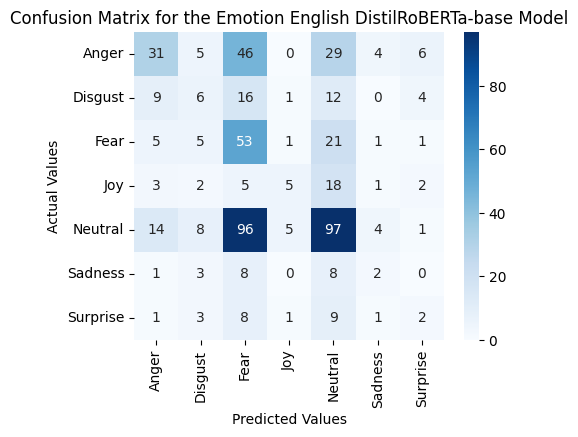

              precision    recall  f1-score   support

       Anger       0.48      0.26      0.34       121
     Disgust       0.19      0.12      0.15        48
        Fear       0.23      0.61      0.33        87
         Joy       0.38      0.14      0.20        36
     Neutral       0.50      0.43      0.46       225
     Sadness       0.15      0.09      0.11        22
    Surprise       0.12      0.08      0.10        25

    accuracy                           0.35       564
   macro avg       0.29      0.25      0.24       564
weighted avg       0.39      0.35      0.34       564



In [157]:
#overall performance
df1=df.dropna(subset=['Emotions'])
cm_class1=confusion_matrix(df1['Emotions'],df1['Emotions class1'])
cm_class1_df = pd.DataFrame(cm_class1,
                     index = ['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise'], 
                     columns = ['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_class1_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the Emotion English DistilRoBERTa-base Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df1['Emotions'],df1['Emotions class1'], target_names=['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise']))

Data for True Information


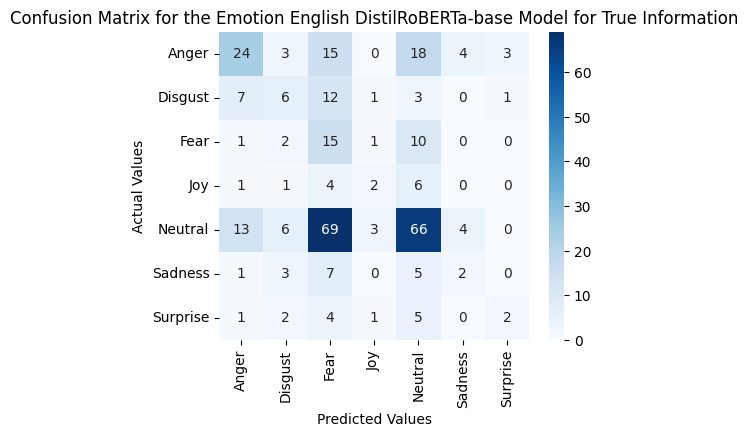

              precision    recall  f1-score   support

       Anger       0.50      0.36      0.42        67
     Disgust       0.26      0.20      0.23        30
        Fear       0.12      0.52      0.19        29
         Joy       0.25      0.14      0.18        14
     Neutral       0.58      0.41      0.48       161
     Sadness       0.20      0.11      0.14        18
    Surprise       0.33      0.13      0.19        15

    accuracy                           0.35       334
   macro avg       0.32      0.27      0.26       334
weighted avg       0.45      0.35      0.38       334

Data for Conspiracy Theory


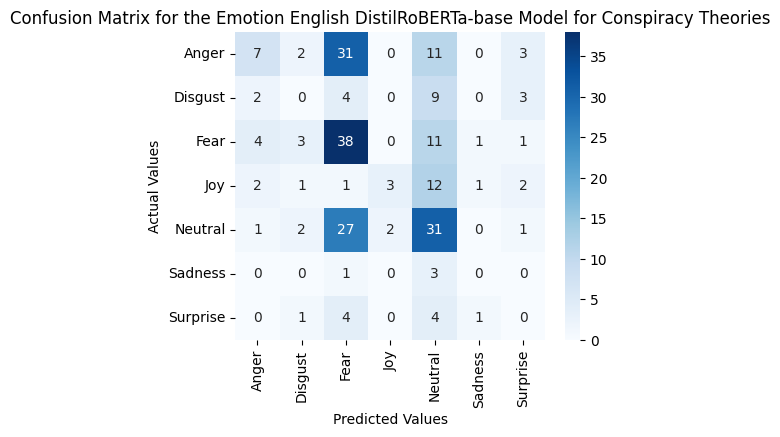

              precision    recall  f1-score   support

       Anger       0.44      0.13      0.20        54
     Disgust       0.00      0.00      0.00        18
        Fear       0.36      0.66      0.46        58
         Joy       0.60      0.14      0.22        22
     Neutral       0.38      0.48      0.43        64
     Sadness       0.00      0.00      0.00         4
    Surprise       0.00      0.00      0.00        10

    accuracy                           0.34       230
   macro avg       0.25      0.20      0.19       230
weighted avg       0.36      0.34      0.30       230



In [158]:
#per class
df_true1=df1[df1['Annotation']==0]
df_consp1=df1[df1['Annotation']==1]
print("Data for True Information")
cm_class1_true=confusion_matrix(df_true1['Emotions'],df_true1['Emotions class1'])
cm_class1_true_df = pd.DataFrame(cm_class1_true,
                     index = ['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise'], 
                     columns = ['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_class1_true_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the Emotion English DistilRoBERTa-base Model for True Information')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df_true1['Emotions'],df_true1['Emotions class1'], target_names=['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise']))
print("Data for Conspiracy Theory")
cm_class1_consp=confusion_matrix(df_consp1['Emotions'],df_consp1['Emotions class1'])
cm_class1_consp_df = pd.DataFrame(cm_class1_consp,
                     index = ['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise'], 
                     columns = ['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_class1_consp_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the Emotion English DistilRoBERTa-base Model for Conspiracy Theories')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(df_consp1['Emotions'],df_consp1['Emotions class1'], target_names=['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise']))

In [ ]:
#emotion fine tuned

In [260]:

reviews1 = df1['Tweet Processes'].tolist()
labels1 = df1['Emotions'].tolist()
train_texts1, val_texts1, train_labels1, val_labels1 = train_test_split(reviews1, labels1, test_size=0.1)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
train_encodings1 = tokenizer(train_texts1, truncation=True, padding=True, max_length=512)
val_encodings1 = tokenizer(val_texts1, truncation=True, padding=True, max_length=512)

train_dataset1 = ReviewDataset(train_encodings1, train_labels1)
val_dataset1 = ReviewDataset(val_encodings1, val_labels1)

train_loader1 = DataLoader(train_dataset1, batch_size=16, shuffle=True)
val_loader1 = DataLoader(val_dataset1, batch_size=16, shuffle=False)

# Initialize model
model1 = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=7)


# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)
for epoch in range(3):  # number of epochs
    model1.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
model1.save_pretrained('emotion_model_RoBERTa')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'Sequential' object has no attribute 'parameters'

In [163]:
# Load the model
model1 = RobertaForSequenceClassification.from_pretrained('emotion_model_RoBERTa')

# Load validation data
val_data1 = df[500::]
val_data1=val_data1.dropna()
val_texts1 = val_data1['Tweet Processes'].tolist()
val_labels1 = val_data1['Emotions'].tolist()

# Initialize tokenizer
tokenizer1 = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenize data
val_encodings1 = tokenizer1(val_texts1, truncation=True, padding=True, max_length=512)

# Create torch dataset for validation


val_dataset1 = ReviewDataset(val_encodings1, val_labels1)
val_loader1 = DataLoader(val_dataset1, batch_size=16, shuffle=False)

# Evaluate the model
model1.eval()
predictions1 = []
true_labels1 = []
for batch in val_loader1:
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']

    with torch.no_grad():
        outputs = model1(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_labels1= torch.argmax(logits, dim=1).cpu().numpy()
    predictions1.extend(predicted_labels1)
    true_labels1.extend(labels.cpu().numpy())

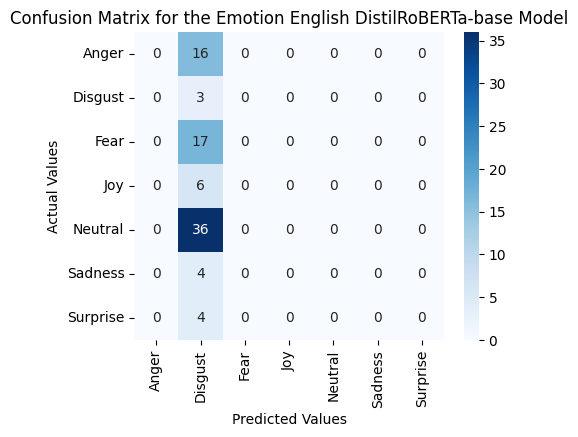

              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        16
     Disgust       0.03      1.00      0.07         3
        Fear       0.00      0.00      0.00        17
         Joy       0.00      0.00      0.00         6
     Neutral       0.00      0.00      0.00        36
     Sadness       0.00      0.00      0.00         4
    Surprise       0.00      0.00      0.00         4

    accuracy                           0.03        86
   macro avg       0.00      0.14      0.01        86
weighted avg       0.00      0.03      0.00        86



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [164]:
cm_class1_ft=confusion_matrix(true_labels1,predictions1)
cm_class1_ft = pd.DataFrame(cm_class1_ft,
                     index = ['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise'], 
                     columns = ['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_class1_ft, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix for the Emotion English DistilRoBERTa-base Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
print(classification_report(true_labels1,predictions1, target_names=['Anger','Disgust','Fear','Joy','Neutral','Sadness','Surprise']))

In [ ]:
#LSTM sentiment

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Tweet1'] = df['Tweet'].apply(clean_text)
df['Tweet1'] = df['Tweet1'].str.replace('\d+', '')

In [220]:

MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df1['Tweet Processes'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3292 unique tokens.


In [221]:
X = tokenizer.texts_to_sequences(df1['Tweet Processes'].values)
X = tf.keras.utils.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (500, 250)


In [222]:
Y = pd.get_dummies(df1['Emotions']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (500, 7)


In [223]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(400, 250) (400, 7)
(100, 250) (100, 7)


In [224]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/10
6/6 [==============================] - 10s 861ms/step - loss: 1.8581 - accuracy: 0.3194 - val_loss: 1.6743 - val_accuracy: 0.4500
Epoch 2/10
6/6 [==============================] - 5s 795ms/step - loss: 1.7187 - accuracy: 0.3806 - val_loss: 1.3629 - val_accuracy: 0.4500
Epoch 3/10
6/6 [==============================] - 5s 783ms/step - loss: 1.6171 - accuracy: 0.3806 - val_loss: 1.3751 - val_accuracy: 0.4500
Epoch 4/10
6/6 [==============================] - 5s 748ms/step - loss: 1.5670 - accuracy: 0.3806 - val_loss: 1.2727 - val_accuracy: 0.4500
Epoch 5/10
6/6 [==============================] - 5s 851ms/step - loss: 1.5389 - accuracy: 0.3806 - val_loss: 1.2972 - val_accuracy: 0.4500
Epoch 6/10
6/6 [==============================] - 4s 722ms/step - loss: 1.5009 - accuracy: 0.3833 - val_loss: 1.3120 - val_accuracy: 0.4500
Epoch 7/10
6/6 [==============================] - 5s 755ms/step - loss: 1.4487 - accuracy: 0.3861 - val_loss: 1.2696 - val_accuracy: 0.4500
Epoch 8/10
6/6 [===

In [225]:
model.predict(X_test, batch_size=1)[0]
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4/4 [==============================] - 0s 96ms/step - loss: 1.4898 - accuracy: 0.4300
Test set
  Loss: 1.490
  Accuracy: 0.430


In [247]:
val_data1 = df[500::]
val_data1=val_data1.dropna()
val_texts1 = val_data1['Tweet Processes'].tolist()
val_labels1 = val_data1['Emotions'].tolist()
results=[]
for sentence in val_texts1:
    seq = tokenizer.texts_to_sequences(sentence)
    padded = tf.keras.utils.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    labels = [0,1,2,3,4,5,6]
    results.append(pred)
    #emotions_labels.append(labels[np.argmax(pred)])
print(results)

2/3 [===================>..........] - ETA: 0s

6/6 [==============================] - 2s 227ms/step
[array([[0.10880997, 0.11677405, 0.20552476, 0.0807863 , 0.35646304,
        0.06178004, 0.06986179],
       [0.12123947, 0.1263554 , 0.22576173, 0.08851653, 0.29567614,
        0.06693768, 0.07551314],
       [0.12123947, 0.1263554 , 0.22576173, 0.08851653, 0.29567614,
        0.06693768, 0.07551314],
       [0.12123947, 0.1263554 , 0.22576173, 0.08851653, 0.29567614,
        0.06693768, 0.07551314],
       [0.11045671, 0.11372025, 0.20299946, 0.07709251, 0.36788633,
        0.05958457, 0.06826016],
       [0.12123947, 0.1263554 , 0.22576173, 0.08851653, 0.29567614,
        0.06693768, 0.07551314],
       [0.10757296, 0.11429198, 0.20131643, 0.08053529, 0.3652972 ,
        0.06171798, 0.06926814],
       [0.10880997, 0.11677405, 0.20552476, 0.0807863 , 0.35646304,
        0.06178004, 0.06986179],
       [0.12123947, 0.1263554 , 0.22576173, 0.08851653, 0.29567614,
        0.06693768, 0.07551314],
       [0.12123947, 0.1263554 , 0.225

In [259]:
results

[array([[0.10880997, 0.11677405, 0.20552476, 0.0807863 , 0.35646304,
         0.06178004, 0.06986179],
        [0.12123947, 0.1263554 , 0.22576173, 0.08851653, 0.29567614,
         0.06693768, 0.07551314],
        [0.12123947, 0.1263554 , 0.22576173, 0.08851653, 0.29567614,
         0.06693768, 0.07551314],
        [0.12123947, 0.1263554 , 0.22576173, 0.08851653, 0.29567614,
         0.06693768, 0.07551314],
        [0.11045671, 0.11372025, 0.20299946, 0.07709251, 0.36788633,
         0.05958457, 0.06826016],
        [0.12123947, 0.1263554 , 0.22576173, 0.08851653, 0.29567614,
         0.06693768, 0.07551314],
        [0.10757296, 0.11429198, 0.20131643, 0.08053529, 0.3652972 ,
         0.06171798, 0.06926814],
        [0.10880997, 0.11677405, 0.20552476, 0.0807863 , 0.35646304,
         0.06178004, 0.06986179],
        [0.12123947, 0.1263554 , 0.22576173, 0.08851653, 0.29567614,
         0.06693768, 0.07551314],
        [0.12123947, 0.1263554 , 0.22576173, 0.08851653, 0.29567614,
    